# Comparison with CLASS

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt
import camb
from classy import Class # import classy module
from scipy.interpolate import interp1d
#%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=12)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=13)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=13)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

In [2]:
# import jax.profiler
# jax.profiler.start_server(9999)

In [3]:
print(camb.__version__)
import classy
print(classy.__version__)

1.5.8
v3.2.3


In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [5]:
## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
Omegac  = Omegam - Omegab
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
# Initialize neutrinos.
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
h       = 0.67742
A_s     = 2.1064e-09
n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 512
kmin = 1e-5
kmax = 1e+2 # 1e+1
aexp = 0.01

In [6]:
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, evolve_perturbations_batched

## Compute Background evolution
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = N_nu_rel
param['Nmnu']    = N_nu_mass
param['mnu']     = mnu

In [7]:
param = evolve_background(param=param, thermo_module='RECFAST')#, class_thermo=thermo)
print(param['Omegamnu'], ' ', mnu / 93.14 / h ** 2)

2024-09-19 15:33:48.267833: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


0.0013900569834351647   0.0014037797968188103


In [8]:
os.environ["OMP_NUM_THREADS"] = "8"
# ## CAMB setup

# Omeganu = mnu / 93.14 / h ** 2
Omeganu = param['Omegamnu']
g = (Tnu / (11/4)**(-1/3))**4 # 11/4 is g_0/g_*
pars = camb.CAMBparams(H0=100*h, ombh2=Omegab*h**2, omch2=Omegac*h**2, omnuh2=Omeganu*h**2, omk=0.0, YHe=YHe, TCMB=Tcmb, 
                        num_nu_massive=N_nu_mass, num_nu_massless=N_nu_rel, nu_mass_eigenstates = 1,
                        nu_mass_fractions=[1.], nu_mass_degeneracies=[g * N_nu_mass], nu_mass_numbers=[1], share_delta_neff=False, MassiveNuMethod='Nu_int' )
                        # nu_mass_fractions=[1.], nu_mass_degeneracies=[0.], nu_mass_numbers=[1], share_delta_neff=True, MassiveNuMethod='Nu_int' )
                        # nu_mass_numbers=[nnu], nu_mass_degeneracies=[Neff / nnu],
                        # nu_mass_fractions=[1.], share_delta_neff=True)
                       #num_nu_massive=num_massive_neutrinos, num_nu_massless=Neff)
#This function sets up with one massive neutrino and helium set using BBN consistency
# pars.set_cosmology(H0=100*h, ombh2=Omegab*h**2, omch2=(Omegam-Omegab)*h**2, mnu=mnu, omk=0., 
#                    tau=None, num_massive_neutrinos=num_massive_neutrinos, standard_neutrino_neff = Neff+num_massive_neutrinos,
#                    nnu=Neff+num_massive_neutrinos, YHe=YHe, TCMB=Tcmb )
pars.set_dark_energy(w=w_DE_0, cs2=cs2_DE, wa=w_DE_a, dark_energy_model='fluid')
pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
pars.set_accuracy(AccuracyBoost=3.0 , DoLateRadTruncation=False, lAccuracyBoost=3.0)
pars.set_matter_power(redshifts=[1/aexp-1], kmax=kmax/h*1.1, accurate_massive_neutrino_transfers=True)
pars.Reion.Reionization = False
pars.Transfer.high_precision = True
pars.Transfer.accurate_massive_neutrinos = True
pars.MassiveNuMethod= 'Nu_int'
results = camb.get_results(pars)
kh_camb, z_camb, pkbc_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.001, maxkh=kmax/h*0.999, npoints = nmodes, var1='delta_nonu', var2='delta_nonu')
kh_camb, z_camb, pkm_camb  = results.get_matter_power_spectrum(minkh=kmin/h*1.001, maxkh=kmax/h*0.999, npoints = nmodes, var1='delta_tot', var2='delta_tot')
kh_camb, z_camb, pkc_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.001, maxkh=kmax/h*0.999, npoints = nmodes, var1='delta_cdm', var2='delta_cdm')
kh_camb, z_camb, pkb_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.001, maxkh=kmax/h*0.999, npoints = nmodes, var1='delta_baryon', var2='delta_baryon')
kh_camb, z_camb, pknu_camb = results.get_matter_power_spectrum(minkh=kmin/h*1.001, maxkh=kmax/h*0.999, npoints = nmodes, var1='delta_nu', var2='delta_nu')

print(z_camb)

[99.0]


In [9]:
import time
## CLASS setup
# create instance of the class "Class"
os.environ["OMP_NUM_THREADS"] = "8"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'Omega_k':0.0,
    'Omega_b':Omegab,
    'Omega_cdm':Omegam-Omegab,
    'N_ur':N_nu_rel,
    'N_ncdm':N_nu_mass,
    'm_ncdm':mnu,
    'T_ncdm':    Tnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    # 'tau_reio':0.06, 
    'gauge':'synchronous',
    'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    # 'compute damping scale' : 'yes',
    # 'tol_perturbations_integration' : 1e-07,
    # 'tol_background_integration' : 1e-07,
    # 'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    #'lensing':'no',
    'P_k_max_1/Mpc': kmax*1.01,
    'z_max_pk':1000.0,
    # 'recombination' : 'HyRec',
    'recombination' : 'RECFAST',
    # # these are high precision reference settings
    # 'start_small_k_at_tau_c_over_tau_h' : 0.0004,
    # 'start_large_k_at_tau_h_over_tau_k' : 0.05,
    # 'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    # 'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    # 'start_sources_at_tau_c_over_tau_h' : 0.006,
    
    'l_max_g' : 31,
    'l_max_pol_g' : 31,
    'l_max_ur' : 31,
    'l_max_ncdm' : 31,
    'Omega_Lambda' : 0.0,
    'w0_fld' : w_DE_0,
    'wa_fld' : w_DE_a,
    'cs2_fld' : 1.0,
    'use_ppf' : 'no',
    'radiation_streaming_approximation' : 2,
    'ncdm_fluid_approximation' : 3,
    'ur_fluid_approximation' : 2,
  })
# run class
tic = time.time()
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()
toc = time.time()

print("elapsed:", toc - tic)

def get_class_power( fieldname, zout ):
  tk, k, z = LambdaCDM.get_transfer_and_k_and_z()
  TT = interp1d( np.log(1/(1+z)), tk[fieldname], axis=1 )( np.log(1/(1+zout)) ) 
  # res =  2*np.pi**2*A_s*(k/k_p*h)**(n_s - 1) * k**(-3) * TT**2 
  res =  2*np.pi**2*A_s*(k/k_p)**(n_s - 1) * k**(-3) * TT**2
  return res, k

elapsed: 125.73603630065918


In [10]:
# nu_fluid_trigger_tau_over_tau_k            = 31.0   # value taken from default CLASS settings
# radiation_streaming_trigger_tau_c_over_tau = 5.0    # value taken from CLASS
# radiation_streaming_trigger_tau_over_tau_k = 45. #45.    # value taken from CLASS

# kk = jnp.geomspace(kmin,kmax,128)
# tau_start = np.array([ jax.jit(determine_starting_time)(param=param,k=kp) for kp in kk])
# tau_fa = np.array([ jnp.maximum(jax.jit(determine_free_streaming_time)(param=param, k=kp, radiation_streaming_trigger_tau_c_over_tau=radiation_streaming_trigger_tau_c_over_tau),radiation_streaming_trigger_tau_over_tau_k/kp) for kp in kk])


# # tau_free_stream = determine_free_streaming_time( param=param, k=kmode,  radiation_streaming_trigger_tau_c_over_tau=radiation_streaming_trigger_tau_c_over_tau)
# #     tau_free_stream = jnp.minimum( jnp.maximum( tau_free_stream, radiation_streaming_trigger_tau_over_tau_k/kmode ), tau_max )

In [11]:
# fig, ax = plt.subplots()
# #
# ax.loglog(kk, tau_start)
# ax.loglog(kk, tau_fa)
# ax.axhline(param['tau_of_a_spline'].evaluate(1.0),c='k',ls='--')

# ax.invert_yaxis()

In [12]:
# Compute Perturbations
aexp_out = jnp.array([aexp]) 

y, kmodes = evolve_perturbations_batched( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,
                                  lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 5,
                                  max_steps=32768,
                                  rtol=1e-5, atol=1e-5, batch_size=32 )

# y, kmodes = evolve_perturbations( param=param1, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   # lmaxg=8,lmaxgp=8,lmaxr=8,lmaxnu=8,nqmax=8,
#                                   # lmaxr = 11, lmaxg = 11, lmaxgp = 11, 
#                                   # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
#                                   # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
#                                   # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 25,
#                                   lmaxg = 31, lmaxgp = 31, lmaxr = 31, lmaxnu = 31, nqmax = 5,
#                                   # lmaxg = 19, lmaxgp = 19, lmaxr = 19, lmaxnu = 19, nqmax = 32,
#                                   # lmaxg = 15, lmaxgp = 7, lmaxr = 15, lmaxnu = 15, nqmax = 3,
#                                   max_steps=32768,
#                                   rtol=1e-5, atol=1e-5)

solution stats: {'max_steps': Array(32768, dtype=int64, weak_type=True), 'num_accepted_steps': Array(7, dtype=int64, weak_type=True), 'num_rejected_steps': Array(0, dtype=int64, weak_type=True), 'num_steps': Array(7, dtype=int64, weak_type=True)}
solution stats: {'max_steps': Array(32768, dtype=int64, weak_type=True), 'num_accepted_steps': Array(9, dtype=int64, weak_type=True), 'num_rejected_steps': Array(0, dtype=int64, weak_type=True), 'num_steps': Array(9, dtype=int64, weak_type=True)}
solution stats: {'max_steps': Array(32768, dtype=int64, weak_type=True), 'num_accepted_steps': Array(15, dtype=int64, weak_type=True), 'num_rejected_steps': Array(3, dtype=int64, weak_type=True), 'num_steps': Array(18, dtype=int64, weak_type=True)}
solution stats: {'max_steps': Array(32768, dtype=int64, weak_type=True), 'num_accepted_steps': Array(20, dtype=int64, weak_type=True), 'num_rejected_steps': Array(4, dtype=int64, weak_type=True), 'num_steps': Array(24, dtype=int64, weak_type=True)}
solution

In [13]:
iout = -1
fac = 2 * np.pi**2 * A_s
Pkc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,8]**2
Pkb = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,10]**2
Pknu = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,16]**2
Pkm = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,4]**2
Pkbc = fac *(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,6]**2

In [23]:
#zout = jnp.maximum(1/y[0,iout,0]-1,0.0)
zout = 1/aexp-1
print(f'z={zout}, aexp={aexp}')

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)
Pknu_CLASS, k_CLASS = get_class_power('d_ncdm[0]', zout)
# Pkbc_CLASS = Omegab/Omegam * Pkb_CLASS + (Omegam-Omegab)/Omegam * Pkc_CLASS
Pkm_CLASS = np.array([LambdaCDM.pk_lin(ki, zout) for ki in k_CLASS])
Pkbc_CLASS = np.array([LambdaCDM.pk_cb_lin(ki, zout) for ki in k_CLASS])

z=99.0, aexp=0.01


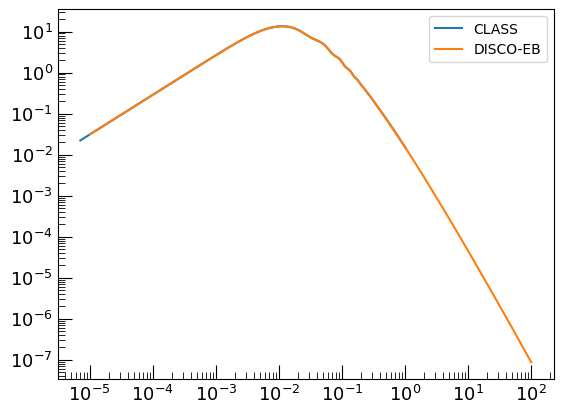

In [24]:
import matplotlib.pyplot as plt
# %matplotlib inline
fig, ax = plt.subplots()

# ax.loglog( kh_camb[1:]*h, pk_camb[0,1:]/h**3, label='CAMB' )
ax.loglog( k_CLASS, Pkbc_CLASS, label='CLASS' )
ax.loglog( kmodes, Pkbc, label='DISCO-EB' )

plt.legend()
plt.show()


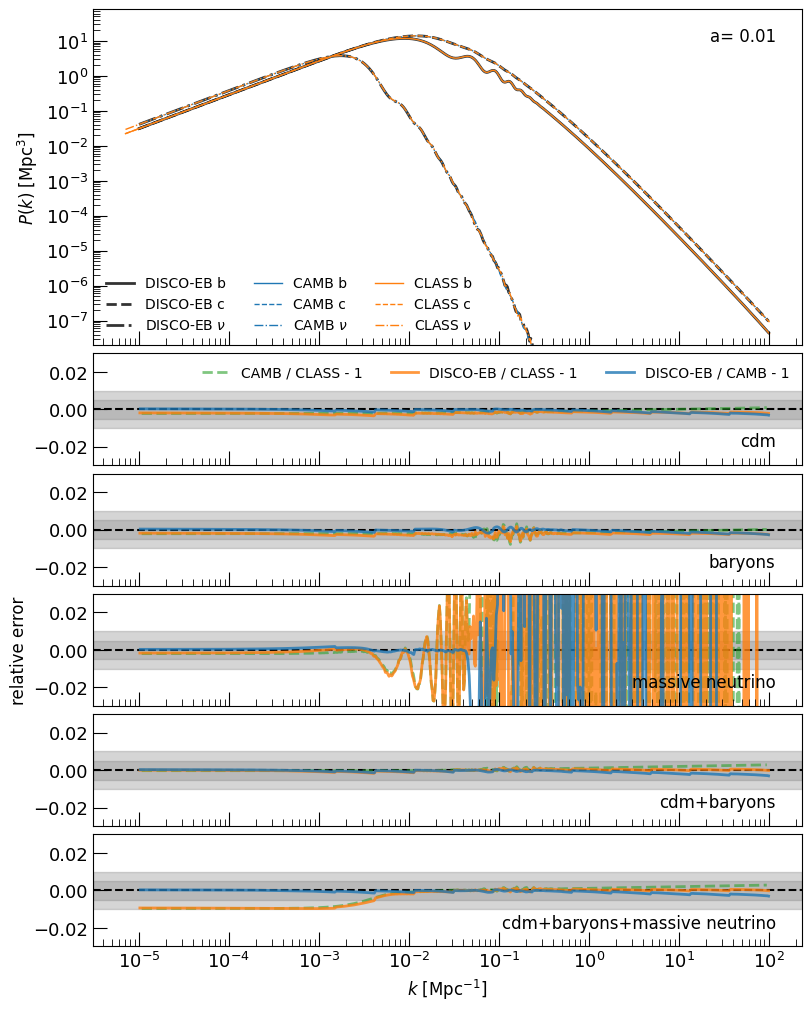

In [16]:

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1]}, layout='constrained', figsize=(8,10))

# ax1.loglog( kh_camb[1:]*h, pkbc_camb[0,1:]/h**3, label='CAMB c+b',lw=1, c='C0', ls = '-' )
# ax1.loglog( kh_camb[1:]*h, pkm_camb[0,1:]/h**3 / 10, label='CAMB c+b+$\\nu$ / 10',lw=1, c='C0', ls = '--' )


if False:

  ax1.axhline(1.0,lw=1.0,ls='--',c='k')

  ax1.plot( kh_camb[1:]*h, pkb_camb[0,1:]/pkm_camb[0,1:], label='CAMB b',lw=1, c='C0', ls = '-' )
  ax1.plot( kh_camb[1:]*h, pkc_camb[0,1:]/pkm_camb[0,1:], label='CAMB c',lw=1, c='C0', ls = '--' )
  ax1.plot( kh_camb[1:]*h, pknu_camb[0,1:]/pkm_camb[0,1:], label='CAMB $\\nu$',lw=1, c='C0', ls = '-.' )

  ax1.plot( k_CLASS, Pkb_CLASS / Pkm_CLASS, label='CLASS b',lw=1, c='C1', ls = '-' )
  ax1.plot( k_CLASS, Pkc_CLASS / Pkm_CLASS, label='CLASS c',lw=1, c='C1', ls = '--' )
  ax1.plot( k_CLASS, Pknu_CLASS / Pkm_CLASS, label='CLASS $\\nu$',lw=1, c='C1', ls = '-.' )

  ax1.plot( kmodes, Pkb / Pkm, label='DISCO-EB b', c='C2', lw=1, ls='-' )
  ax1.plot( kmodes, Pkc / Pkm, label='DISCO-EB c', c='C2', lw=1, ls='--' )
  ax1.plot( kmodes, Pknu / Pkm, label='DISCO-EB $\\nu$', c='C2', lw=1, ls='-.' )
  ax1.semilogx()
  ax1.set_ylim(0.0, 1.5)

else:

  ax1.plot( kmodes, Pkb, label='DISCO-EB b', c='k', lw=2, ls='-' , alpha=0.8)
  ax1.plot( kmodes, Pkc, label='DISCO-EB c', c='k', lw=2, ls='--' , alpha=0.8)
  ax1.plot( kmodes, Pknu, label='DISCO-EB $\\nu$', c='k', lw=2, ls='-.' , alpha=0.8)

  ax1.plot( kh_camb[1:]*h, pkb_camb[0,1:] /h**3, label='CAMB b',lw=1, c='C0', ls = '-' )
  ax1.plot( kh_camb[1:]*h, pkc_camb[0,1:] /h**3, label='CAMB c',lw=1, c='C0', ls = '--' )
  ax1.plot( kh_camb[1:]*h, pknu_camb[0,1:] /h**3, label='CAMB $\\nu$',lw=1, c='C0', ls = '-.' )

  ax1.plot( k_CLASS, Pkb_CLASS, label='CLASS b',lw=1, c='C1', ls = '-' )
  ax1.plot( k_CLASS, Pkc_CLASS, label='CLASS c',lw=1, c='C1', ls = '--' )
  ax1.plot( k_CLASS, Pknu_CLASS, label='CLASS $\\nu$',lw=1, c='C1', ls = '-.' )

  ax1.loglog()
  ax1.set_ylim(2e-4 * aexp**2, 800000 * aexp**2)

ax1.set_ylabel(r'$P(k)$ [Mpc$^{3}$]')
ax1.legend(frameon=False,ncol=3)
ax1.text(120,100000 * aexp**2, f'a={aexp : .2f}', fontsize=12, horizontalalignment='right')

for a in (ax2,ax3,ax4,ax5,ax6):

  a.axhline(0, color='k', ls='--')
  # add gray shaded area indicating per cent level residual
  a.axhspan(-0.01, 0.01, alpha=0.33, color='gray')
  a.axhspan(-0.005, 0.005, alpha=0.33, color='gray')
  #a.set_ylim(-0.0799,0.0799)
  a.set_ylim(-0.0299, 0.0299)  
  # a.set_xlim(10e-6,10)
  # a.set_ylabel('relative error')

def plot_resids( ax, k_CLASS, P_CLASS, k_CAMB, P_CAMB, k_DISCO, P_DISCO, labelstr ):
  iC = jnp.where( (k_CLASS > k_DISCO[0]) & (k_CLASS < k_DISCO[-1]) )[0]
  iC2 = jnp.where( (k_CLASS > k_CAMB[2]*h) & (k_CLASS < k_CAMB[-2]*h) )[0]

  # Interpolate the DISCO-EB curve to the same x-values as the other two curves
  f  = interp1d(jnp.log(k_DISCO), jnp.log(P_DISCO) )
  g  = interp1d(jnp.log(k_CAMB[1:]*h), jnp.log(P_CAMB[0,1:]/h**3) )
  P_interp_CAMB  = jnp.exp( f( jnp.log(k_CAMB[1:]*h) ) )
  P_interp_CLASS = jnp.exp( f( jnp.log(k_CLASS[iC]) ) )

  P_interp_CLASS_CAMB = jnp.exp( g( jnp.log(k_CLASS[iC2]) ) )

  # Plot the residual
  ax.semilogx(k_CLASS[iC2], (P_interp_CLASS_CAMB - P_CLASS[iC2]) / P_CLASS[iC2], label='CAMB / CLASS - 1', c='C2',ls='--', lw=2,alpha=0.6)
  ax.semilogx(k_CLASS[iC], (P_interp_CLASS - P_CLASS[iC]) / P_CLASS[iC], label='DISCO-EB / CLASS - 1', c='C1',lw=2,alpha=0.8)
  ax.semilogx(k_CAMB[1:]*h, (P_interp_CAMB - P_CAMB[0,1:]/h**3) / (P_CAMB[0,1:]/h**3), label='DISCO-EB / CAMB - 1', c='C0',lw=2,alpha=0.8)
  ax.text(120,-0.02, labelstr, fontsize=12, horizontalalignment='right')
  return 

exclude = 60
plot_resids( ax2, k_CLASS, Pkc_CLASS, kh_camb, pkc_camb, kmodes, Pkc, 'cdm')
plot_resids( ax3, k_CLASS, Pkb_CLASS, kh_camb, pkb_camb, kmodes, Pkb, 'baryons')
plot_resids( ax4, k_CLASS, Pknu_CLASS, kh_camb, pknu_camb, kmodes, Pknu, 'massive neutrino')
plot_resids( ax5, k_CLASS, Pkbc_CLASS, kh_camb, pkbc_camb, kmodes, Pkbc, 'cdm+baryons')
plot_resids( ax6, k_CLASS, Pkm_CLASS, kh_camb, pkm_camb, kmodes, Pkm, 'cdm+baryons+massive neutrino')
# plot_resids( ax4, k_CLASS, Pkb_CLASS, kh_camb, pkb_camb, kmodes, Pkb, 'b')


# # Interpolate the DISCO-EB curve to the same x-values as the other two curves
# f  = interp1d(jnp.log(kmodes), jnp.log(Pkm) )
# g  = interp1d(jnp.log(kh_camb[1:]*h), jnp.log(pkm_camb[0,1:]/h**3) )
# Pkm_interp_camb  = jnp.exp( f( jnp.log(kh_camb[1:]*h) ) )
# Pkm_interp_class = jnp.exp( f( jnp.log(k_CLASS[iC]) ) )

# Pkm_interp_class_camb = jnp.exp( g( jnp.log(k_CLASS[iC2]) ) )

# # Plot the residual
# ax3.semilogx(kh_camb[1:]*h, (Pkm_interp_camb - pkm_camb[0,1:]/h**3) / (pkm_camb[0,1:]/h**3), label='DISCO-EB / CAMB - 1', c='C0',lw=1)
# ax3.semilogx(k_CLASS[iC], (Pkm_interp_class - Pkm_CLASS[iC]) / Pkm_CLASS[iC], label='DISCO-EB / CLASS - 1', c='C1',lw=1)
# ax3.semilogx(k_CLASS[iC2], (Pkm_interp_class_camb - Pkm_CLASS[iC2]) / Pkm_CLASS[iC2], label='CAMB / CLASS - 1', c='C3',lw=1)
# ax3.text(30,-0.02, 'c+b+$\\nu$', fontsize=12)


ax2.legend(ncol=3,frameon=False)
  

ax4.set_ylabel('relative error')
ax6.set_xlabel(r'$k$ [Mpc$^{-1}$]')

plt.show()
# plt.savefig(f'comparison_class_camb_a{aexp:.2f}_new.pdf',bbox_inches='tight')


In [17]:
## evaluate the power spectra
iout = -1
print(f'DISCO-EB zout={1/y[0,iout,0]-1}')
zout = jnp.maximum(1/y[0,iout,0]-1,0.0)

Pkc = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,3]**2 
Pkb = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,5]**2 
Pkg = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,7]**2 

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)

DISCO-EB zout=-2.0000048228404874


In [18]:
LambdaCDM.set({
    'recombination' : 'HyRec',
    'P_k_max_1/Mpc': 1.0,
  })
# run class
tic = time.time()
LambdaCDM.compute()
thermo2 = LambdaCDM.get_thermodynamics()
toc = time.time()

print("elapsed:", toc - tic)

elapsed: 1.7008800506591797


In [19]:
import copy
param2 = copy.deepcopy( param )
param2 = evolve_background(param=param2, thermo_module='MB95')#, class_thermo=thermo)

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

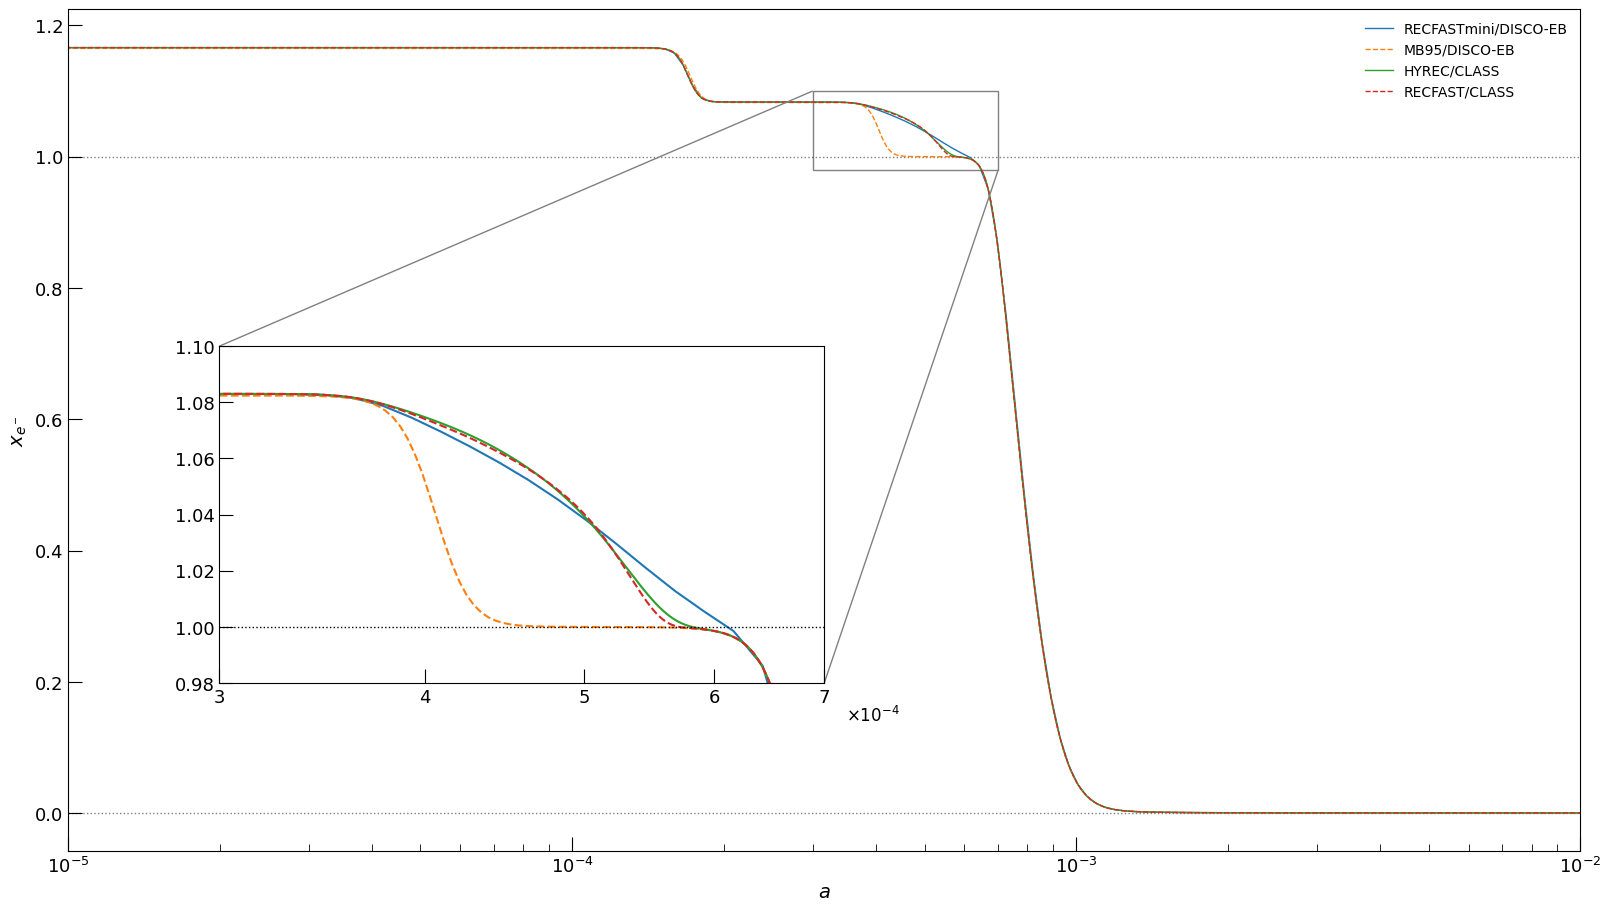

In [21]:
# plot thermal evolution
# fg, ax = plt.subplots(2,sharex=True, layout='constrained', figsize=(6,6))
fg, ax = plt.subplots(figsize=(8,4),layout='constrained')
fg.set_size_inches(16, 9)
# for aa in ax:
ax.axhline(0.0,c='k',ls=':',lw=1,alpha=0.5)
ax.axhline(1.0,c='k',ls=':',lw=1,alpha=0.5)

xe = param['xe_of_tau_spline'].evaluate(param['tau_of_a_spline'].evaluate(param['a']))
a=  param['a']
xe2 = param2['xe_of_tau_spline'].evaluate(param2['tau_of_a_spline'].evaluate(param2['a']))
a2=  param2['a']

ax.semilogx( a, xe,  lw=1, label='RECFASTmini/DISCO-EB' )
ax.semilogx( a2, xe2,'--',  lw=1, label='MB95/DISCO-EB' )
ax.semilogx( 1/(1+thermo2['z']), thermo2['x_e'], lw=1, label='HYREC/CLASS' )
ax.semilogx( 1/(1+thermo['z']), thermo['x_e'], '--', lw=1, label='RECFAST/CLASS' )


# create inset axes
axins = ax.inset_axes([0.1, 0.2, 0.4, 0.4])

# plot zoomed-in data on inset axes
axins.semilogx( a, xe,  lw=1.5, label='$x_{e^-}$ RECFASTmini/DISCO-EB' )
axins.semilogx( a2, xe2,  '--',  lw=1.5, label='$x_{e^-}$ MB95/DISCO-EB' )
axins.semilogx( 1/(1+thermo2['z']), thermo2['x_e'], lw=1.5, label='$x_{e^-}$ HYREC/CLASS' )
axins.semilogx( 1/(1+thermo['z']), thermo['x_e'], '--',lw=1.5, label='$x_{e^-}$ RECFAST/CLASS' )
axins.set_xlim(3.0e-4,0.7e-3)
axins.set_xticks([3e-4,4e-4,5e-4,6e-4,7e-4])
axins.set_xticklabels(['3','4','5','6','7'])
axins.set_ylim(0.98,1.1)
axins.axhline(1.0,c='k',ls=':',lw=1)

# draw lines between main axes and inset axes
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax.text(3.5e-4,0.14,'$\\times10^{-4}$',size=12)
# create inset axes
# axins2 = ax.inset_axes([0.7, 0.2, 0.3, 0.4])

# axins2.loglog(a, xe,  lw=1, label='$x_{e^-}$ RECFASTmini/DISCO-EB' )
# axins2.loglog( a2, xe2,  lw=1, label='$x_{e^-}$ MB95/DISCO-EB' )
# axins2.loglog( 1/(1+thermo['z']), thermo['x_e'], lw=1, label='$x_{e^-}$ RECFAST/CLASS' )
# axins2.loglog( 1/(1+thermo2['z']), thermo2['x_e'], lw=1, label='$x_{e^-}$ HYREC/CLASS' )
# axins2.set_xlim(1e-3,1.0)
# axins2.set_ylim(1e-4,1e-3)


# ax[1].semilogx( param['th']['a'], param['th']['xHII'], lw=1, label='$x_\\mathrm{H^{+}}$ MB95/DISCO-EB' )
# ax[1].semilogx( param['th']['a'], param['th']['xHeII'], lw=1, label='$x_\\mathrm{He^{+}}$ MB95/DISCO-EB' )
# ax[1].semilogx( param['th']['a'], param['th']['xHeIII'], lw=1, label='$x_\\mathrm{He^{++}}$ MB95/DISCO-EB' )
# for a in ax: 
leg = ax.legend(frameon=False)
ax.set_ylabel('$x_{e^-}$',size=14)
ax.set_xlabel('$a$',size=14)
ax.set_xlim(1e-5,1e-2)
# ax[1].set_xlabel('$a$')

# plt.savefig('thermodynamics.pdf',bbox_inches='tight')
plt.show()